# Klasyfikacja mieszkań

# Analiza danych

In [28]:
import pandas as pd
from matplotlib import pyplot as plt
data = pd.read_csv('train_data.csv')

### Analiza wstępna

In [29]:
# data.info()
# data.describe()
data.head()
# data.isnull().sum()

# plt.hist(data['SalePrice'])
# plt.title("Sale Price")
# plt.show()

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


### Etykietowanie

In [30]:
data["Class"] = 0
data.loc[(data['SalePrice'] > 100000) & (data['SalePrice'] <= 350000), "Class"] = 1
data.loc[data["SalePrice"] > 350000, "Class"] = 2
data['Class'].value_counts()
data.drop('SalePrice', axis=1, inplace=True)

### Obróbka danych dyskretnych

In [ ]:
no_numeric_data = ["HallwayType", "HeatingType", "AptManageType", "SubwayStation"]
no_numeric_order_data = ["TimeToBusStop", "TimeToSubway"]

# for column in no_numeric_data + no_numeric_order_data:
#   print(data[column].value_counts())

# sprawdzenie czy każde mieszkanie które nie ma obok przystanku nie ma też metra -> TAK
# len(data[data['TimeToSubway'] == 'no_bus_stop_nearby']) == \
# len(data[(data['TimeToSubway'] == 'no_bus_stop_nearby') & (data['SubwayStation'] == 'no_subway_nearby')])

unique_times = data['TimeToBusStop'].dropna().unique()
time_mapping = {
    '0~5min': 0,
    '5min~10min': 1,
    '10min~15min': 2,
    '15min~20min': 3,
}
data['TimeToBusStop'] = data['TimeToBusStop'].map(time_mapping)

mapping = {
    '0-5min': 0,
    '5min~10min': 1,
    '10min~15min': 2,
    '15min~20min': 3,
    'no_bus_stop_nearby': 4
}
data['TimeToSubway'] = data['TimeToSubway'].map(mapping)

print(data['TimeToBusStop'].value_counts(dropna=False))
print(data['TimeToSubway'].value_counts(dropna=False))

for column in no_numeric_data:
  dummies = pd.get_dummies(data[column], drop_first=True)
  dummies = dummies.astype(int)
  data = pd.concat([data, dummies], axis=1)
  data = data.drop(column, axis=1)

# data.head()
data.drop('no_subway_nearby', axis=1, inplace=True)
data.info()

TimeToBusStop
1    2984
0     938
4     164
2      38
Name: count, dtype: int64
TimeToSubway
0    1960
3     682
1     680
2     526
4     276
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4124 entries, 0 to 4123
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   YearBuilt                  4124 non-null   int64  
 1   Size(sqf)                  4124 non-null   int64  
 2   Floor                      4124 non-null   int64  
 3   N_Parkinglot(Ground)       4124 non-null   float64
 4   N_Parkinglot(Basement)     4124 non-null   float64
 5   TimeToBusStop              4124 non-null   int64  
 6   TimeToSubway               4124 non-null   int64  
 7   N_manager                  4124 non-null   float64
 8   N_elevators                4124 non-null   float64
 9   N_FacilitiesInApt          4124 non-null   int64  
 10  N_FacilitiesNearBy(Total)  4124 non-null   floa

### Korelacja danych

In [5]:
import seaborn as sns

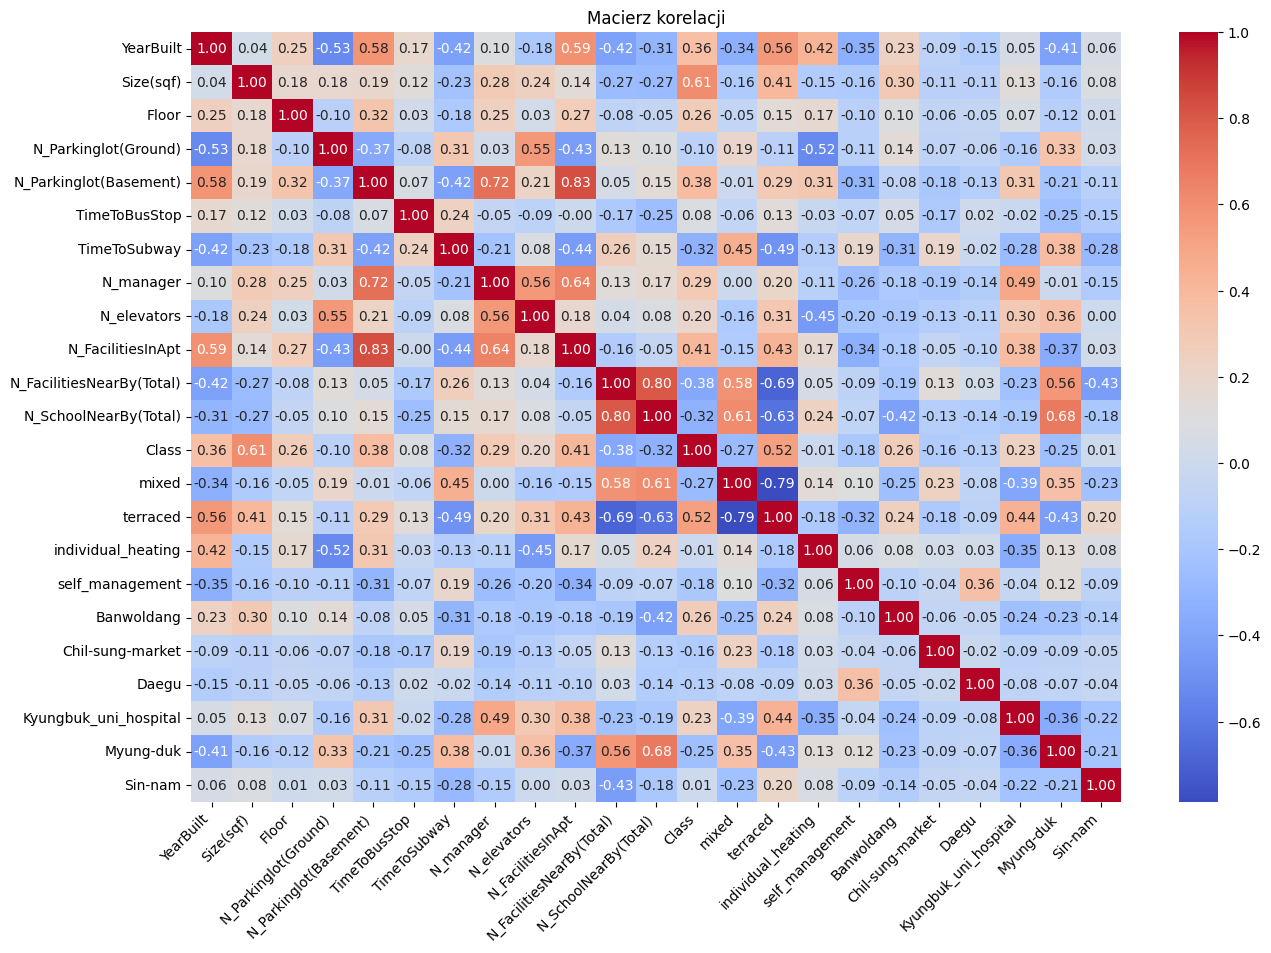

In [6]:
correlation_matrix = data.corr()
plt.figure(figsize=(15, 10))  # Ustaw rozmiar wykresu
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Macierz korelacji')
plt.show()

In [7]:
# odrzcenie nisko skorelowanych danych - współczynnik korelacji w przedziale [-0.2; 0.2]
data.drop(['N_Parkinglot(Ground)', 'TimeToBusStop','N_elevators', 'individual_heating',
           'self_management', 'Chil-sung-market', 'Daegu', 'Sin-nam'], axis=1, inplace=True)

# Model

In [8]:
!nvidia-smi

Mon Mar 24 14:00:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.83                 Driver Version: 572.83         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   57C    P0             28W /   85W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

## Podział danych

In [10]:
train, valid = train_test_split(data, test_size=0.2, random_state=42)

train_dataset = TensorDataset(torch.tensor(train.drop('Class', axis=1).values, dtype=torch.float),
                              torch.tensor(train['Class'].values, dtype=torch.float))
valid_dataset = TensorDataset(torch.tensor(valid.drop('Class', axis=1).values, dtype=torch.float),
                              torch.tensor(valid['Class'].values, dtype=torch.float))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

## Parametry modelu i procesu uczenia

In [16]:
PARAMS = {
    'lr': 0.001,
    'epochs': 1000,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'inputs': len(train_dataset[0][0]),
    'layers': [1024, 512, 256, 128],
    'outputs': 1
}

class_counts = torch.tensor(data['Class'].value_counts().sort_index())
print(class_counts)
class_counts[1] = class_counts[1] * 0.3
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(PARAMS['device'])
print(class_weights)

tensor([ 562, 2992,  570])
tensor([0.3828, 0.2398, 0.3774], device='cuda:0')


## Architektura Modelu

In [17]:
class ApartmentClassificator(nn.Module):
    def __init__(self, input_size, hid_layers, output_size):
        super(ApartmentClassificator, self).__init__()
        layers = []
        in_features = input_size
        
        for hidden_size in hid_layers:
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            in_features = hidden_size

        layers.append(nn.Linear(in_features, output_size))
        self.model = nn.Sequential(*layers)
        

    def forward(self, x):
        return self.model(x)

## Pętla uczenia

In [18]:
model = ApartmentClassificator(PARAMS['inputs'], PARAMS['layers'], PARAMS['outputs']).to(PARAMS['device'])
def weighted_mse_loss(outputs, labels, weights):
    classes = torch.where(labels <= 0.5, 0, 
                torch.where(labels <= 1.5, 1, 2)).long()
    sample_weights = weights[classes]
    loss = (sample_weights * (outputs - labels).pow(2)).mean()
    return loss
optimizer = optim.Adam(model.parameters(), lr=PARAMS['lr'])

for epoch in range(PARAMS['epochs']):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(PARAMS['device']), labels.to(PARAMS['device'])
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze(dim=1)
        loss = weighted_mse_loss(outputs, labels, class_weights)
        loss.backward()
        optimizer.step()

    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(PARAMS['device']), labels.to(PARAMS['device'])
            outputs = model(inputs)
            outputs = outputs.squeeze(dim=1)
            loss = weighted_mse_loss(outputs, labels, class_weights)
            valid_loss += loss.item() * inputs.size(0)

    valid_loss /= len(valid_loader.dataset)

    if epoch % 20 == 0:
      print(f'Epoch [{epoch+1}/{PARAMS["epochs"]}], Train Loss: {loss.item():.4f}, Valid Loss: {valid_loss:.4f}')

Epoch [1/1000], Train Loss: 0.0455, Valid Loss: 0.0425
Epoch [21/1000], Train Loss: 0.0370, Valid Loss: 0.0396
Epoch [41/1000], Train Loss: 0.0325, Valid Loss: 0.0367
Epoch [61/1000], Train Loss: 0.0283, Valid Loss: 0.0294
Epoch [81/1000], Train Loss: 0.0242, Valid Loss: 0.0301
Epoch [101/1000], Train Loss: 0.0299, Valid Loss: 0.0324
Epoch [121/1000], Train Loss: 0.0327, Valid Loss: 0.0387
Epoch [141/1000], Train Loss: 0.0279, Valid Loss: 0.0294
Epoch [161/1000], Train Loss: 0.0237, Valid Loss: 0.0310
Epoch [181/1000], Train Loss: 0.0278, Valid Loss: 0.0299
Epoch [201/1000], Train Loss: 0.0255, Valid Loss: 0.0304
Epoch [221/1000], Train Loss: 0.0262, Valid Loss: 0.0290
Epoch [241/1000], Train Loss: 0.0258, Valid Loss: 0.0291
Epoch [261/1000], Train Loss: 0.0277, Valid Loss: 0.0316
Epoch [281/1000], Train Loss: 0.0209, Valid Loss: 0.0293
Epoch [301/1000], Train Loss: 0.0260, Valid Loss: 0.0297
Epoch [321/1000], Train Loss: 0.0259, Valid Loss: 0.0288
Epoch [341/1000], Train Loss: 0.0233,

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Epoch [1000/1000], Train Loss: 0.0244, Valid Loss: 0.0272, Valid Accuracy: 0.8642


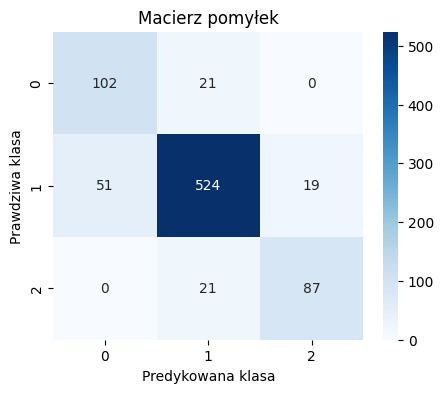

              precision    recall  f1-score   support

         0.0       0.67      0.83      0.74       123
         1.0       0.93      0.88      0.90       594
         2.0       0.82      0.81      0.81       108

    accuracy                           0.86       825
   macro avg       0.80      0.84      0.82       825
weighted avg       0.87      0.86      0.87       825



In [19]:
# Obliczenie accuracy
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(PARAMS['device']), labels.to(PARAMS['device'])
        outputs = model(inputs)
        outputs = outputs.squeeze(dim=1)
        
        # Konwersja na klasy
        predicted_classes = torch.zeros_like(outputs, dtype=torch.int64)  # Inicjalizacja tablicy z klasami
        predicted_classes[outputs <= 0.5] = 0  # Klasa 'cheap'
        predicted_classes[(outputs > 0.5) & (outputs <= 1.5)] = 1  # Klasa 'average'
        predicted_classes[outputs > 1.5] = 2  # Klasa 'expensive'

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted_classes.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions)
conf_matrix = confusion_matrix(all_labels, all_predictions)
classification_rep = classification_report(all_labels, all_predictions)

# Wyświetlenie accuracy
print(f'Epoch [{epoch+1}/{PARAMS["epochs"]}], Train Loss: {loss.item():.4f}, Valid Loss: {valid_loss:.4f}, Valid Accuracy: {accuracy:.4f}')

# Create a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Macierz pomyłek')
plt.xlabel('Predykowana klasa')
plt.ylabel('Prawdziwa klasa')
plt.show()

print(classification_rep)

## Predykcje modelu

### Import i preprocessing danych

In [38]:
test = pd.read_csv('test_data.csv')

no_numeric_data = ["HallwayType", "HeatingType", "AptManageType", "SubwayStation"]
no_numeric_order_data = ["TimeToBusStop", "TimeToSubway"]

unique_times = test['TimeToBusStop'].dropna().unique()
time_mapping = {time: i for i, time in enumerate(unique_times)}
test['TimeToBusStop'] = test['TimeToBusStop'].map(time_mapping)

test.loc[test['TimeToSubway'] == 'no_bus_stop_nearby', 'TimeToBusStop'] = 4
mapping = {
    '0-5min': 0,
    '5min~10min': 1,
    '10min~15min': 2,
    '15min~20min': 3,
    'no_bus_stop_nearby': 4
}
test['TimeToSubway'] = test['TimeToSubway'].map(mapping)
test.loc[test['SubwayStation'] == 'no_subway_nearby', "TimeToSubway"] = 4

for column in no_numeric_data:
  dummies = pd.get_dummies(test[column], drop_first=True)
  dummies = dummies.astype(int)
  test = pd.concat([test, dummies], axis=1)
  test = test.drop(column, axis=1)

test.drop('no_subway_nearby', axis=1, inplace=True)
test.drop(['N_Parkinglot(Ground)', 'TimeToBusStop','N_elevators', 'individual_heating',
           'self_management', 'Chil-sung-market', 'Daegu', 'Sin-nam'], axis=1, inplace=True)

In [39]:
test.columns

Index(['YearBuilt', 'Size(sqf)', 'Floor', 'N_Parkinglot(Basement)',
       'TimeToSubway', 'N_manager', 'N_FacilitiesInApt',
       'N_FacilitiesNearBy(Total)', 'N_SchoolNearBy(Total)', 'mixed',
       'terraced', 'Banwoldang', 'Kyungbuk_uni_hospital', 'Myung-duk'],
      dtype='object')

### Wykonanie predykcji

In [40]:
import numpy as np

In [41]:
test_dataset = TensorDataset(torch.tensor(test.values, dtype=torch.float))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()

all_predictions = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(PARAMS['device'])
        outputs = model(inputs)
        all_predictions.extend(outputs.cpu().numpy())

all_predictions = np.concatenate(all_predictions)

predicted_classes = np.zeros_like(all_predictions, dtype=object)
predicted_classes[all_predictions <= 0.5] = 0
predicted_classes[(all_predictions > 0.5) & (all_predictions <= 1.5)] = 1
predicted_classes[all_predictions > 1.5] = 2

In [42]:
pd.DataFrame({'Class': predicted_classes}).to_csv('pred.csv', index=False, header=False)